In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [ ]:
RAW_PATH = os.path.join("..", "data", "raw.csv")
assert os.path.exists(RAW_PATH), f"File not found: {RAW_PATH}. Put your dataset at ../data/raw.csv"

df_raw = pd.read_csv(RAW_PATH)

print("Loaded:", RAW_PATH)
print("Shape:", df_raw.shape)
df_raw.head(5)

Loaded: ..\data\raw.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print("Columns:", df_raw.columns.tolist())
print("\n--- Dtypes ---")
display(df_raw.dtypes)

print("\n--- Missing values (top 25) ---")
missing = df_raw.isna().sum().sort_values(ascending=False)
display(missing.head(25))

print("\n--- Duplicate rows ---")
print("Duplicates:", df_raw.duplicated().sum())

print("\n--- Target distribution (Churn) ---")
if "Churn" in df_raw.columns:
    display(df_raw["Churn"].value_counts())
    display(df_raw["Churn"].value_counts(normalize=True))
else:
    raise ValueError("Column 'Churn' not found. Check dataset columns.")

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

--- Dtypes ---


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


--- Missing values (top 25) ---


customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
gender              0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
SeniorCitizen       0
Churn               0
dtype: int64


--- Duplicate rows ---
Duplicates: 0

--- Target distribution (Churn) ---


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [4]:
df = df_raw.copy()

# Drop customerID if exists (it should)
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# Handle TotalCharges: it often comes as string with blanks.
# Convert to numeric; blanks become NaN.
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
else:
    raise ValueError("Column 'TotalCharges' not found. Check dataset.")

# Drop rows where TotalCharges is missing after conversion
before = df.shape[0]
df = df.dropna(subset=["TotalCharges"])
after = df.shape[0]
print(f"Dropped {before - after} rows due to invalid TotalCharges. New shape: {df.shape}")

# Quick check
df[["TotalCharges"]].describe()

Dropped 11 rows due to invalid TotalCharges. New shape: (7032, 20)


,TotalCharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


In [5]:
# Convert churn target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Verify conversion
print(df["Churn"].value_counts())
print(df["Churn"].value_counts(normalize=True))

Churn
0    5163
1    1869
Name: count, dtype: int64
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


In [6]:
# Tenure is usually numeric already
if "tenure" not in df.columns:
    raise ValueError("Column 'tenure' not found. Check dataset columns.")

df["TenureGroup"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 48, 72, np.inf],
    labels=["0-1y", "1-2y", "2-4y", "4-6y", "6y+"],
    include_lowest=True
)

df[["tenure", "TenureGroup"]].head(10)

,tenure,TenureGroup
0,1,0-1y
1,34,2-4y
2,2,0-1y
3,45,2-4y
4,2,0-1y
5,8,0-1y
6,22,1-2y
7,10,0-1y
8,28,2-4y
9,62,4-6y


In [7]:
# Keep a human-readable copy for later Tableau export
# (We'll merge predictions back into this after modeling)
business_cols = [
    "Churn",
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "TenureGroup"
]

# Optional columns (some might not exist depending on dataset version)
optional_cols = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod"
]

# Only keep the ones that exist
existing_optional = [c for c in optional_cols if c in df.columns]
business_view = df[business_cols + existing_optional].copy()

print("Business view columns:", business_view.columns.tolist())
business_view.head(5)

Business view columns: ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges', 'TenureGroup', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,Churn,tenure,MonthlyCharges,TotalCharges,TenureGroup,gender,SeniorCitizen,Partner,Dependents,PhoneService,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0,1,29.85,29.85,0-1y,Female,0,Yes,No,No,...,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,0,34,56.95,1889.50,2-4y,Male,0,No,No,Yes,...,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,1,2,53.85,108.15,0-1y,Male,0,No,No,Yes,...,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,0,45,42.30,1840.75,2-4y,Male,0,No,No,No,...,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,1,2,70.70,151.65,0-1y,Female,0,No,No,Yes,...,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


In [8]:
# Build ML dataset:
# - Keep target as numeric
# - One-hot encode categorical columns
# - Drop_first to avoid multicollinearity for logistic regression baseline

target = "Churn"
X_raw = df.drop(columns=[target])
y = df[target].astype(int)

# One-hot encode
X = pd.get_dummies(X_raw, drop_first=True)

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head(3)

X shape: (7032, 34)
y shape: (7032,)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_1-2y,TenureGroup_2-4y,TenureGroup_4-6y,TenureGroup_6y+
0,0,1,29.85,29.85,False,True,False,False,True,False,...,False,False,True,False,True,False,False,False,False,False
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,True,False,False,False,False,True,False,True,False,False
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,True,False,False,True,False,False,False,False


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (5625, 34) (5625,)
Test : (1407, 34) (1407,)


In [10]:
baseline = LogisticRegression(max_iter=2000, n_jobs=None)  # n_jobs not supported in all sklearn versions
baseline.fit(X_train, y_train)

baseline_probs = baseline.predict_proba(X_test)[:, 1]
baseline_pred = (baseline_probs >= 0.5).astype(int)

baseline_auc = roc_auc_score(y_test, baseline_probs)
print("Baseline ROC-AUC:", round(baseline_auc, 4))

print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, baseline_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, baseline_pred))

Baseline ROC-AUC: 0.8356

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

Confusion matrix:
[[922 111]
 [179 195]]


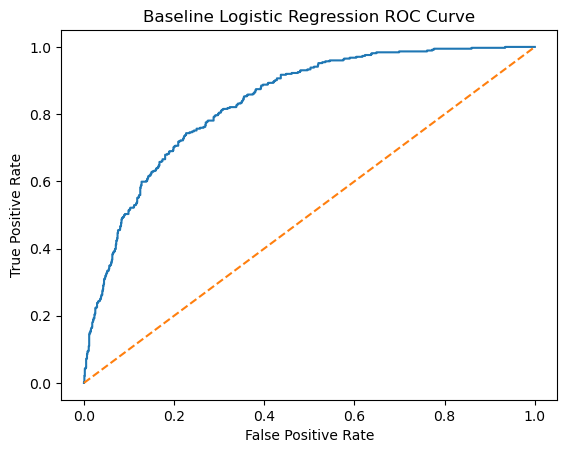

In [11]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, baseline_probs)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Baseline Logistic Regression ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [12]:
# LightGBM import (make sure installed: pip install lightgbm)
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

lgb.fit(X_train, y_train)

lgb_probs = lgb.predict_proba(X_test)[:, 1]
lgb_pred = (lgb_probs >= 0.5).astype(int)

lgb_auc = roc_auc_score(y_test, lgb_probs)
print("LightGBM ROC-AUC:", round(lgb_auc, 4))

print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, lgb_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, lgb_pred))

  File "c:\Users\pc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\pc\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\pc\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
LightGBM ROC-AUC: 0.8191

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1033
           1       0.58      0.52      0.55       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      

In [13]:
prec, rec, thr = precision_recall_curve(y_test, lgb_probs)

# precision_recall_curve returns thresholds of length n-1
# We’ll compute F1 for each threshold and select the best
f1_scores = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thr[best_idx]

print("Best threshold (max F1):", round(float(best_threshold), 4))
print("Best F1:", round(float(f1_scores[best_idx]), 4))

# Show report at best threshold
best_pred = (lgb_probs >= best_threshold).astype(int)
print("\nClassification report (best threshold):")
print(classification_report(y_test, best_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, best_pred))

Best threshold (max F1): 0.2569
Best F1: 0.6115

Classification report (best threshold):
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1033
           1       0.52      0.75      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407

Confusion matrix:
[[769 264]
 [ 93 281]]


In [15]:
# Predict probabilities for all rows using the trained LGBM model
# Note: X is the full one-hot encoded dataset aligned to train columns already
df_probs = lgb.predict_proba(X)[:, 1]

print("Probabilities generated:", df_probs.shape)
print("Min/Max:", df_probs.min(), df_probs.max())

Probabilities generated: (7032,)
Min/Max: 4.985703611331516e-06 0.9927357976098893


In [16]:
def segment_risk(p: float) -> str:
    if p >= 0.70:
        return "High"
    elif p >= 0.40:
        return "Medium"
    else:
        return "Low"

risk_segment = pd.Series(df_probs).apply(segment_risk)

risk_segment.value_counts()

Low       4924
High      1183
Medium     925
Name: count, dtype: int64

In [17]:
# revenue_at_risk = churn_probability * MonthlyCharges
# This is a proxy for expected monthly revenue loss.
if "MonthlyCharges" not in business_view.columns:
    raise ValueError("MonthlyCharges missing from business_view. Check dataset columns.")

churn_probability = pd.Series(df_probs, name="churn_probability")
revenue_at_risk = churn_probability * business_view["MonthlyCharges"].astype(float)

# Quick sanity checks
print(revenue_at_risk.describe())

count    7021.000000
mean       17.019790
std        23.846175
min         0.000300
25%         0.298811
50%         4.895267
75%        24.324209
max       110.311243
dtype: float64


In [19]:
print("df shape:", df.shape)

print("business_view shape:", business_view.shape)
print("X shape:", X.shape)

print("len(df_probs):", len(df_probs))

# Index checks (this is the real truth)
print("business_view index:", business_view.index.min(), "->", business_view.index.max())
print("X index:", X.index.min(), "->", X.index.max())

missing_in_business = X.index.difference(business_view.index)
missing_in_X = business_view.index.difference(X.index)

print("Rows in X but NOT in business_view:", len(missing_in_business))
print("Rows in business_view but NOT in X:", len(missing_in_X))

# Show a few problematic indices (if any)
display(missing_in_business[:10])
display(missing_in_X[:10])

df shape: (7032, 21)
business_view shape: (7032, 21)
X shape: (7032, 34)
len(df_probs): 7032
business_view index: 0 -> 7042
X index: 0 -> 7042
Rows in X but NOT in business_view: 0
Rows in business_view but NOT in X: 0


Index([], dtype='int64')

Index([], dtype='int64')

In [20]:
churn_probability = pd.Series(df_probs, index=X.index, name="churn_probability")

In [21]:
# Align business_view to the exact rows used in X
business_aligned = business_view.reindex(X.index)

# If you want to only keep rows that exist in both (recommended):
business_aligned = business_aligned.dropna(subset=["MonthlyCharges"])  # safe guard

# Align churn_probability to the same final index
churn_probability = churn_probability.loc[business_aligned.index]

In [22]:
def segment_risk(p: float) -> str:
    if p >= 0.70:
        return "High"
    elif p >= 0.40:
        return "Medium"
    return "Low"

risk_segment = churn_probability.apply(segment_risk)

revenue_at_risk = churn_probability * business_aligned["MonthlyCharges"].astype(float)

In [23]:
tableau_df = business_aligned.copy()
tableau_df["churn_probability"] = churn_probability
tableau_df["risk_segment"] = risk_segment
tableau_df["revenue_at_risk"] = revenue_at_risk

# If you want threshold flag
tableau_df["predicted_churn_flag"] = (tableau_df["churn_probability"] >= best_threshold).astype(int)

print("tableau_df shape:", tableau_df.shape)
tableau_df.head(10)

tableau_df shape: (7032, 25)


,Churn,tenure,MonthlyCharges,TotalCharges,TenureGroup,gender,SeniorCitizen,Partner,Dependents,PhoneService,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,churn_probability,risk_segment,revenue_at_risk,predicted_churn_flag
0,0,1,29.85,29.85,0-1y,Female,0,Yes,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,0.438331,Medium,13.084188,1
1,0,34,56.95,1889.50,2-4y,Male,0,No,No,Yes,...,No,No,No,One year,No,Mailed check,0.002547,Low,0.145074,0
2,1,2,53.85,108.15,0-1y,Male,0,No,No,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,0.663129,Medium,35.709486,1
3,0,45,42.30,1840.75,2-4y,Male,0,No,No,No,...,Yes,No,No,One year,No,Bank transfer (automatic),0.004300,Low,0.181889,0
4,1,2,70.70,151.65,0-1y,Female,0,No,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,0.571932,Medium,40.435580,1
5,1,8,99.65,820.50,0-1y,Female,0,No,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,0.984650,High,98.120359,1
6,0,22,89.10,1949.40,1-2y,Male,0,No,Yes,Yes,...,No,Yes,No,Month-to-month,Yes,Credit card (automatic),0.285103,Low,25.402675,1
7,0,10,29.75,301.90,0-1y,Female,0,No,No,No,...,No,No,No,Month-to-month,No,Mailed check,0.208503,Low,6.202969,0
8,1,28,104.80,3046.05,2-4y,Female,0,Yes,No,Yes,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,0.912349,High,95.614186,1
9,0,62,56.15,3487.95,4-6y,Male,0,No,Yes,Yes,...,No,No,No,One year,No,Bank transfer (automatic),0.019981,Low,1.121923,0


In [24]:
# Check if High risk holds most revenue-at-risk (usually should)
summary = tableau_df.groupby("risk_segment").agg(
    customers=("risk_segment", "count"),
    avg_churn_prob=("churn_probability", "mean"),
    total_revenue_at_risk=("revenue_at_risk", "sum"),
    avg_monthly=("MonthlyCharges", "mean"),
    churn_rate=("Churn", "mean")  # actual churn rate in that segment
).sort_values("total_revenue_at_risk", ascending=False)

summary

,customers,avg_churn_prob,total_revenue_at_risk,avg_monthly,churn_rate
risk_segment,,,,,
High,1183,0.828551,76342.728053,77.648732,0.922232
Medium,925,0.564967,37446.406826,71.134703,0.649730
Low,4924,0.072478,24697.673365,60.520502,0.035946


In [25]:
OUT_PATH = os.path.join("..", "data", "predictions.csv")
tableau_df.to_csv(OUT_PATH, index=False)

print("Saved:", OUT_PATH)
print("Shape exported:", tableau_df.shape)

Saved: ..\data\predictions.csv
Shape exported: (7032, 25)


In [26]:
import joblib

MODEL_PATH = os.path.join("..", "model", "churn_lgbm.pkl")
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

joblib.dump(lgb, MODEL_PATH)
print("Model saved:", MODEL_PATH)

Model saved: ..\model\churn_lgbm.pkl
